# Laboratorijska vježba - Obrada informacija - Neuronske mreže

In [ ]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install torchsummary
!pip install numpy matplotlib opencv-python

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

from torchsummary import summary

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Zadatak 1 - Klasifikacija slike rukom pisanih znamenki

U prvom zadatku ove laboratorijske vježbe želimo analizirati utjecaj arhitekture mreže i drugih hiperparametara na uspješnost predikcije. Vaš zadatak je složiti nekoliko modela različitih karakteristika, te će te te modele istrenirati na problemu klasifikacije rukom pisanih znamenki.

Veliki dio koda koji je potreban za provođenje vježbe je dan. Vi ćete riješiti zadatak nadopunjavanjem koda. Također ste slobodni izmjeniti predloženi kod, ali ne preporuča se. Za labos je potreban Python 3.8+ i PyTorch 1.6+.

## Učitavanje podataka

Sljedeći kod priprema MNIST Dataset objekte koji dolaze s PyTorch paketom. Također instanciramo i DataLoader objekte koji rukuju sa mješanjem i batchanjem skupa podataka.

In [ ]:
batch_size_train = 64
batch_size_test = 64

train_set = torchvision.datasets.MNIST('./files/', train=True, download=True,
                                       transform=torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize((0.1307,), (0.3081,))])
                                      )


test_set = torchvision.datasets.MNIST('./files/', train=False, download=True,
                                      transform=torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize((0.1307,), (0.3081,))])
                                     )

100%|██████████| 9912422/9912422 [00:00<00:00, 175281462.62it/s]

Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 24486697.76it/s]


Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 53258158.24it/s]

Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20288103.05it/s]


Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw



In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size_test, shuffle=True)

#### Podzadatak a)
Prikažite nekoliko primjera iz skupa za testiranje. Sliku pokažite pomoću `matplotlib` funkcije `imshow`. Neka `title` prikazane slike bude labela uzorka.

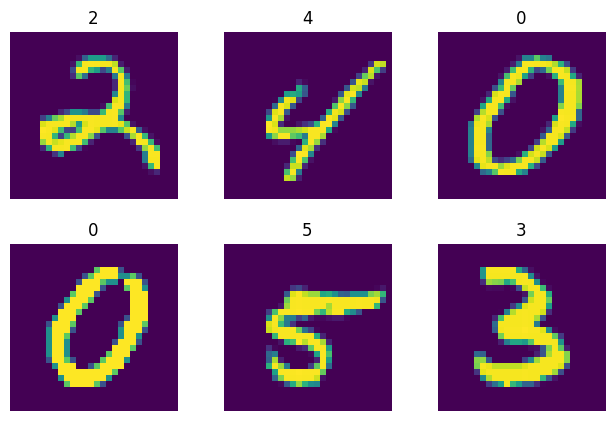

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    # ----
    img = example_data[i]
    title = example_targets[i].item()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.title(str(title))
    plt.axis('off')
    # ----

plt.show()

## Pomoćne metode za treniranje neuronskih mreža

Nakon podzadataka ove sekcije postoji skup testova na kojima možete provjeriti točnost vaših pomoćnih funkcija. Bez točno rješenih pomoćnih funkcija ostatak labosa ne možete riješiti.

#### Podzadatak b) - Funkcija za određivanje broja parametara PyTorch modela

Jedna od metoda usporedbe naših modela će biti po broju parametara koji čine taj model. Radi toga je potrebno napisati metodu `get_number_of_model_parameters(model)` koja za predani model `model` vraća ukupni broj parametara tog modela.
Svaki PyTorch model sadrži implementaciju metode `.parameters()` koja vraća iterator nad parametrima modela. Ti parametri su tipa `torch.nn.parameter.Parameter`, čije dimenzije možemo dobiti pomoću `.shape` propertya.
Dovršite traženu metodu.

In [ ]:
def get_number_of_model_parameters(model):
    return sum(p.numel() for p in model.parameters())


#### Podzadatak c) - Funkcija za treniranje modela

Model se trenira u četiri koraka.

1. Izračuna se prolaz unaprijed nad jednim batchom.
2. Na temelju dobivenog izlaza i točnih labela se računa gubitak. Kako je pokazano u demonstracijskoj bilježnici.
3. Izračunata greška se propagira unazad kroz mrežu radi računanja gradijenata.
4. Na temelju gradijenata, vrijednosti parametara i parametrima optimizatora (koji optimizator se koristi, kolika je stopa učenja, momentum i slično) se računa nova vrijednost parametara modela.

Implementirajte te korake u funkciji `train_step(train_loader, epoch, device, verbose)`.  

Napomene:
* Grešku koju trebate računati je "negative log likelihood loss", za koju PyTorch nudi implementaciju. Preporučamo da koristite gotovu implementaciju loss funkcije.
* Računanje gradijenata pomoću propagacije greške u nazad se računa pomoću metode `.backward()`. Nad kojim elementom pozivamo tu metodu?
* Korak optimizacije se radi pomoću `.step()` metode optimizator objekta. Pretpostavite da postoji objekt `optimizer` u globalnom scopeu.
* Pripazite da Vam se gradijenti ne akumuliraju kroz više koraka optimizacije. PyTorch modeli nude metodu `.zero_grad()` koja postavlja vrijednosti svih gradijenata nekog modela na 0.


In [ ]:
def train_step(network, train_loader, epoch, device, verbose=True):
    train_losses = []
    train_counter = []

    network.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        # -------
        # 1. Korak racunam prolaz unaprijed
        output = network(data)

        # 2. Korak racunam negative log likelihood loss
        loss = F.nll_loss(output, target)

        # 3. Korak propagacija greske unazad
        optimizer.zero_grad()
        loss.backward()

        # 4. Korak optimizacija
        optimizer.step()
        # -----------

        if (batch_idx % log_interval == 0):
            if verbose:
                print('Train Epoch: {:5d} [{:5d}/{:5d} ({:2.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item()))

            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

    return train_losses, train_counter

#### Podzadatak d) - Funkcija za evaluaciju modela

Uspješnost učenja određujemo pomoću metrika točnosti. U ovoj laboratorijskoj vježbi pratimo dvije metrike - `negative log likelihood` i `accuracy`. Sa NLLLoss smo se već susreli; accuracy definiramo kao:

$ accuracy = \frac{\text{number of correctly classified samples}}{\text{total number of samples}} $

Nadopunite funkciju `test(network, test_loader, device, verbose)` tako da se model evaluira za navedene metrike.

U predloženom kodu se koristi `with torch.no_grad()`. Kako tijekom evaluacije ne mjenjamo parametre modela, gradijent nam nije potreban. Time ubrzavamo računanje (ne računa se gradijent), štedimo memoriju (izračunati gradijent se ne sprema) i spriječavamo buduće probleme (npr. ostanu gradijenti do sljedeće faze treniranja, gdje se gradijenti test seta iskoriste za učenje).

In [ ]:
def test(network, test_loader, device, verbose=True):
    network.eval()

    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)

            # -----
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim = 1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # -------

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    if verbose:
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {:5d}/{:5d} ({:2.2f}%)\n'.format(
            test_loss,
            correct,
            len(test_loader.dataset),
            accuracy))

    return test_loss, accuracy

U sljedećoj fazi laboratorijske vježbe izvršavamo eksperimente, spremamo rezultate i uspoređujemo. Rezultate ćemo spremati u mapi `results`, tako da će `key` mape biti naziv eksperimenta, a vrijednost će biti `tuple` koji sadrži vrijednosti po kojima se model uspoređuje.

In [ ]:
results = dict()

#### Podzadatak e) - Funkcija za provođenje cijelokupnog eksperimenta nad jednim modelom

Sada je vrijeme da se koraci iz prethodnih podzadataka objedine. Funkcija `train_network(network, train_loader, test_loader, device)` radi po sljedećem principu:

* Pretpostavlja se da u globalnom scopeu postoji varijabla imena `n_epochs` koja nam govori koliko epoha će se eksperiment izvršavati
* Liste `train_losses` i `test_losses` skupljaju loss vrijednosti tijekom treniranja, dok `train_counter` i `test_counter` skupljaju trenutke u kojima se metrika zabilježila (drugim riječima, to su X i Y os na grafu "loss po vremenu")
* prije samog treniranja se vrši testiranje modela, da se utvrdi performansa slučajnog modela
* U svakoj epohi se model trenira, testira i rezultati se zapisuju u odgovarajuće liste
* Funkcija vraća te liste na kraju

In [ ]:
def train_network(network, train_loader, test_loader, device='cpu'):
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    # ----- testiranje slucajnog modela
    test_accuracy = []
    test_loss, accuracy = test(network, test_loader, device)
    test_accuracy.append(accuracy)
    # -------------
    test_losses.append(test_loss)

    for epoch in range(1, n_epochs + 1):
        # --------- treniranje modela
        new_train_losses, new_train_counter = train_step(network, train_loader, epoch, device)
        test_loss, accuracy = test(network, test_loader, device)
        test_accuracy.append(accuracy)
        # ---------

        train_losses.extend(new_train_losses)
        train_counter.extend(new_train_counter)
        test_losses.append(test_loss)

    return train_losses, train_counter, test_losses, test_counter, test_accuracy

#### Testovi za utvrđivanje točnosti rada pomoćnih funkcija

Sljedeći kod služi kao pomoć za provjeru ispravnosti gore traženih pomoćnih funkcija. Generira se dataset u dva odvojena skupa, i cilj je naučiti model koji klasificira iz kojeg skupa točka dolazi. Prvo generiramo podatke i slažemo DataLoader:

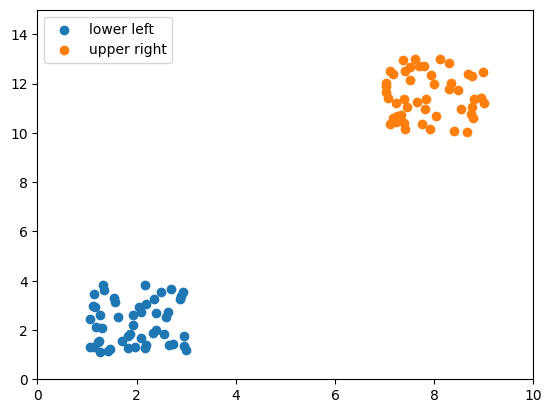

In [ ]:
data_x = np.hstack([np.random.uniform(1, 3, 50), np.random.uniform(7, 9, 50)])
data_y = np.hstack([np.random.uniform(1, 4, 50), np.random.uniform(10, 13, 50)])
labels = [0 if x < 50 else 1 for x in range(0, 100)]

for idx, unique_label in enumerate(["lower left", "upper right"]):
    if idx == 0:
        plt.scatter(data_x[0:50], data_y[0:50], label=unique_label)
    if idx == 1:
        plt.scatter(data_x[50:], data_y[50:], label=unique_label)

plt.legend()
plt.xlim(0, 10)
plt.ylim(0, 15)


tensor_x = torch.Tensor(np.dstack([data_x, data_y]).reshape(100, 2).astype(np.float32))
tensor_y = torch.Tensor(labels).to(dtype=torch.int64)

toy_dataset = TensorDataset(tensor_x, tensor_y)
toy_dataloader = DataLoader(toy_dataset, batch_size=1, shuffle=True)

Nakon toga definiramo naš model. U ovom slučaju je model dvoslojna mreža sa dva potpuno povezana sloja.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

Podešavamo parametre koje naše pomoćne funkcije očekivaju, te instanciramo model i optimizator.

In [ ]:
n_epochs = 30
learning_rate = 0.01
log_interval = 33

network = Net().to('cuda')
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

I sada možemo trenirati naš model. Vaše funkcije su ispravne ako točnost doesgne 100% (ili barem jako blizu). **Bez ispravnih pomoćnih funkcija nećete moći riješiti ostatak labosa.**

In [ ]:
train_network(network, toy_dataloader, toy_dataloader, 'cuda')


Test set: Avg. loss: 1.4609, Accuracy:    50/  100 (50.00%)

Train Epoch:     1 [    0/  100 ( 0%)]	Loss: 0.365846
Train Epoch:     1 [   33/  100 (33%)]	Loss: 0.626095
Train Epoch:     1 [   66/  100 (66%)]	Loss: 0.779353
Train Epoch:     1 [   99/  100 (99%)]	Loss: 0.249881

Test set: Avg. loss: 0.5390, Accuracy:    68/  100 (68.00%)

Train Epoch:     2 [    0/  100 ( 0%)]	Loss: 0.793164
Train Epoch:     2 [   33/  100 (33%)]	Loss: 0.181283
Train Epoch:     2 [   66/  100 (66%)]	Loss: 0.537980
Train Epoch:     2 [   99/  100 (99%)]	Loss: 0.537555

Test set: Avg. loss: 0.4742, Accuracy:    73/  100 (73.00%)

Train Epoch:     3 [    0/  100 ( 0%)]	Loss: 0.025623
Train Epoch:     3 [   33/  100 (33%)]	Loss: 0.932981
Train Epoch:     3 [   66/  100 (66%)]	Loss: 0.928673
Train Epoch:     3 [   99/  100 (99%)]	Loss: 0.190543

Test set: Avg. loss: 0.5060, Accuracy:    99/  100 (99.00%)

Train Epoch:     4 [    0/  100 ( 0%)]	Loss: 0.475519
Train Epoch:     4 [   33/  100 (33%)]	Loss: 0.034

([0.3658459484577179,
  0.6260954141616821,
  0.7793534994125366,
  0.24988116323947906,
  0.7931636571884155,
  0.18128284811973572,
  0.5379800200462341,
  0.5375545620918274,
  0.02562291920185089,
  0.9329812526702881,
  0.9286730289459229,
  0.19054335355758667,
  0.475519061088562,
  0.034788087010383606,
  1.0371191501617432,
  0.8658480644226074,
  0.24864111840724945,
  0.4380567669868469,
  1.0907751321792603,
  0.1239895299077034,
  1.0580477714538574,
  0.6032753586769104,
  0.42145979404449463,
  0.1346287876367569,
  1.1174989938735962,
  0.5396548509597778,
  0.38089895248413086,
  0.36988142132759094,
  0.24098218977451324,
  0.21009878814220428,
  0.3774877190589905,
  0.7446848154067993,
  1.1496319770812988,
  0.7090997695922852,
  1.1558418273925781,
  1.1369596719741821,
  0.13196715712547302,
  0.08270829916000366,
  0.3970221281051636,
  0.5664894580841064,
  1.099238395690918,
  0.4278961420059204,
  0.3987791836261749,
  1.081732988357544,
  0.6068585515022278,

## Provođenje eksperimenata i analiza rezultata

#### Podzadatak f) - Eksperimenti

Sljedeća faza labosa je korištenje naših funkcija u okviru eksperimenata. Potrebno je testirati sljedeće modele:

* **Plitki model sa uskim slojevima**
    * Model je plitak po tome što nema puno slojeva (ne ide u dubinu) i uzak po tome što sami slojevi nemaju veliki broj elemenata (npr. 1 sloj sa 100 neurona umjesto 10 slojeva sa 10 neurona)
    * Arhitektura modela je sljedeća:
        * Konvolucijski sloj 5x5x10
        * Dropout (za regularizaciju)
        * Max pooling
        * ReLU aktivacija
        * Potpuno povezani sloj sa 20 neurona, ReLU aktivacija
        * Potpuno povezani sloj za klasifikaciju u 10 klasa, log softmax aktivacijska funkcija
    * U `results` mapi se sprema pod ključem `shallow_and_narrow_{stopa učenja}`
* **Plitki model sa širokim slojevima**
    * Ovaj model također nema puno slojeva, ali ti slojevi imaju puno elemenata
    * Arhitektura modela je sljedeća:
        * Konvolucijski sloj 5x5x40
        * Dropout (za regularizaciju)
        * Max pooling
        * ReLU aktivacija
        * Potpuno povezani sloj sa 64 neurona, ReLU aktivacija
        * Potpuno povezani sloj za klasifikaciju u 10 klasa, log softmax aktivacijska funkcija
    * U `results` mapi se sprema pod ključem `shallow_and_wide_{stopa učenja}`
* **Duboki model sa uskim slojevima**
    * Ovaj model ima puno slojeva, ali su ti slojevi ograničeni u svojoj širini
    * Arhitektura modela je sljedeća:
        * Konvolucijski sloj 5x5x10, ReLU aktivacijska funkcija
        * Max pooling
        * Konvolucijski sloj 5x5x20, ReLU aktivacijska funkcija
        * Max pooling
        * Potpuno povezani sloj sa 64 neurona, ReLU aktivacija
        * Dropout (za regularizaciju)
        * Potpuno povezani sloj za klasifikaciju u 10 klasa, log softmax aktivacijska funkcija
    * U `results` mapi se sprema pod ključem `deep_and_narrow_{stopa učenja}`
* **Duboki model sa širokim slojevima**
    * Model koji ima sve komponente dobro (ili previše?) zastupljene.
    * Arhitektura modela je sljedeća:
        * Konvolucijski sloj 5x5x32, ReLU aktivacijska funkcija
        * Max pooling
        * Konvolucijski sloj 5x5x64, ReLU aktivacijska funkcija
        * Max pooling
        * Potpuno povezani sloj sa 50 neurona, ReLU aktivacija
        * Dropout (za regularizaciju)
        * Potpuno povezani sloj za klasifikaciju u 10 klasa, log softmax aktivacijska funkcija
    * U `results` mapi se sprema pod ključem `deep_and_wide_{stopa učenja}`


Implementirajte `.__init__(self)` i `.forward(self, x)` metode za svaki od opisanih modela, trenirajte ih, evaluirajte i spremite metrike. **Ponovite taj postupak za 3 različite stope učenja: 0.0000001, 0.01 i 1.**

Sve potrebne slojeve za ostvarenje navedenih modela možete pronaći u torch.nn modulu. Detalje možete pronaći u službenoj PyTorch dokumentaciji: https://pytorch.org/docs/stable/index.html

**Spremite si najbolji model. Biti će potreban u podzadatku h)**.

Prvo je potrebno podesiti parametre. Parametri su sljedeći:
* n_epochs - broj epoha eksperimenta
* learning_rate - stopa učenja
* log_interval - broj koraka između dva ispisa tijekom treniranja (ispis se događa samo ako se funkcija poziva s argumentom verbose=True)
* device - oznaka na kojem se uređaju izvršava eksperiment; "cuda" za GPU, "cpu" za CPU

In [ ]:
learning_rates = [0.0000001, 0.01, 1]

n_epochs = 3
learning_rate = 0.01
log_interval = 100
device = 'cuda'

Naš model definiramo u klasi "Net" koja nasljeđuje nn.Module. Nadjačajte metode `__init__(self)` i `forward(self, x)` kako je opisano u tekstu zadatka.

In [ ]:
# shallow and narrow
class ShallowNarrow(nn.Module):
    def __init__(self):
        super(ShallowNarrow, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.fc1 = nn.Linear(10 * 12 * 12, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = x.view(-1, 10 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# shallow_and_wide
class ShallowWide(nn.Module):
    def __init__(self):
        super(ShallowWide, self).__init__()
        self.conv1 = nn.Conv2d(1, 40, kernel_size=5)
        self.fc1 = nn.Linear(40 * 12 * 12, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = x.view(-1, 40 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# deep_and_narrow
class DeepNarrow(nn.Module):
    def __init__(self):
        super(DeepNarrow, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(20 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 20 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# deep_and_wide
class DeepWide(nn.Module):
    def __init__(self):
        super(DeepWide, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(64 * 4 * 4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Da bi trenirali naš model, potrebno je napraviti instancu mreže i optimizatora. Koristite Stohastic Gradient Descent optimizator iz torch.optim modula. Detalji se mogu pronaći u službenoj dokuemntaciji PyTorcha za optim modul: https://pytorch.org/docs/stable/optim.html

In [ ]:

network1 = ShallowNarrow().to(device)
network2 = ShallowWide().to(device)
network3 = DeepNarrow().to(device)
network4 = DeepWide().to(device)
# ----
optimizer = optim.SGD(network1.parameters(), lr=learning_rate)
# ---------

Iskoristimo našu pripremljenu funkciju za izvođenje eksperimenta:

In [ ]:
train_losses, train_counter, test_losses, test_counter, test_accuracy = train_network(network1, train_loader, test_loader, device)

optimizer = optim.SGD(network2.parameters(), lr=learning_rate)
train_losses2, train_counter2, test_losses2, test_counter2, test_accuracy2 = train_network(network2, train_loader, test_loader, device)

optimizer = optim.SGD(network3.parameters(), lr=learning_rate)
train_losses3, train_counter3, test_losses3, test_counter3, test_accuracy3 = train_network(network3, train_loader, test_loader, device)

optimizer = optim.SGD(network4.parameters(), lr=learning_rate)
train_losses4, train_counter4, test_losses4, test_counter4, test_accuracy4 = train_network(network4, train_loader, test_loader, device)


Test set: Avg. loss: 2.3096, Accuracy:   720/10000 (7.20%)

Train Epoch:     1 [    0/60000 ( 0%)]	Loss: 2.297967
Train Epoch:     1 [ 6400/60000 (11%)]	Loss: 0.985992
Train Epoch:     1 [12800/60000 (21%)]	Loss: 0.703310
Train Epoch:     1 [19200/60000 (32%)]	Loss: 0.495366
Train Epoch:     1 [25600/60000 (43%)]	Loss: 0.431107
Train Epoch:     1 [32000/60000 (53%)]	Loss: 0.336678
Train Epoch:     1 [38400/60000 (64%)]	Loss: 0.342511
Train Epoch:     1 [44800/60000 (75%)]	Loss: 0.647132
Train Epoch:     1 [51200/60000 (85%)]	Loss: 0.216273
Train Epoch:     1 [57600/60000 (96%)]	Loss: 0.146802

Test set: Avg. loss: 0.2488, Accuracy:  9293/10000 (92.93%)

Train Epoch:     2 [    0/60000 ( 0%)]	Loss: 0.109393
Train Epoch:     2 [ 6400/60000 (11%)]	Loss: 0.240595
Train Epoch:     2 [12800/60000 (21%)]	Loss: 0.195847
Train Epoch:     2 [19200/60000 (32%)]	Loss: 0.248886
Train Epoch:     2 [25600/60000 (43%)]	Loss: 0.285931
Train Epoch:     2 [32000/60000 (53%)]	Loss: 0.147870
Train Epoch: 

Spremimo rezultate u mapu `results` kako je navedeno u zadatku. Također nam je potreban broj parametara mreže, što možemo izračunati u ovom koraku.

In [ ]:
# shallow_and_narrow
number_of_parameters1 = get_number_of_model_parameters(network1)
results[f'shallow_and_narrow_{learning_rate}'] = (train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters1)

# shallow_and_wide
number_of_parameters2 = get_number_of_model_parameters(network2)
results[f'shallow_and_wide_{learning_rate}'] = (train_counter2, train_losses2, test_counter2, test_losses2, test_accuracy2, number_of_parameters2)

# deep_and_narrow
number_of_parameters3 = get_number_of_model_parameters(network3)
results[f'deep_and_narrow_{learning_rate}'] = (train_counter3, train_losses3, test_counter3, test_losses3, test_accuracy3, number_of_parameters3)

# deep_and_wide
number_of_parameters4 = get_number_of_model_parameters(network4)
results[f'deep_and_wide_{learning_rate}'] = (train_counter4, train_losses4, test_counter4, test_losses4, test_accuracy4, number_of_parameters4)

In [ ]:
print(results)

{'shallow_and_narrow_1': ([0, 6400, 12800, 19200, 25600, 32000, 38400, 44800, 51200, 57600, 60000, 66400, 72800, 79200, 85600, 92000, 98400, 104800, 111200, 117600, 120000, 126400, 132800, 139200, 145600, 152000, 158400, 164800, 171200, 177600], [2.368098497390747, 2.2912933826446533, 2.3069372177124023, 2.300323009490967, 2.30370831489563, 2.304274320602417, 2.3012595176696777, 2.3034071922302246, 2.31503963470459, 2.3143727779388428, 2.304534912109375, 2.3089301586151123, 2.297825336456299, 2.2828128337860107, 2.298790454864502, 2.3265469074249268, 2.3192358016967773, 2.3099629878997803, 2.3028321266174316, 2.3064236640930176, 2.306671619415283, 2.2931253910064697, 2.3157360553741455, 2.306894302368164, 2.3042328357696533, 2.3302855491638184, 2.30488920211792, 2.3080461025238037, 2.2964236736297607, 2.3077547550201416], [0, 60000, 120000, 180000], [2.346034377670288, 2.3050088333129883, 2.3048055587768554, 2.3023163410186767], [7.08, 10.32, 11.35, 11.35], 29290), 'shallow_and_wide_1'

Prikažimo rezultate za ovaj eksperiment:

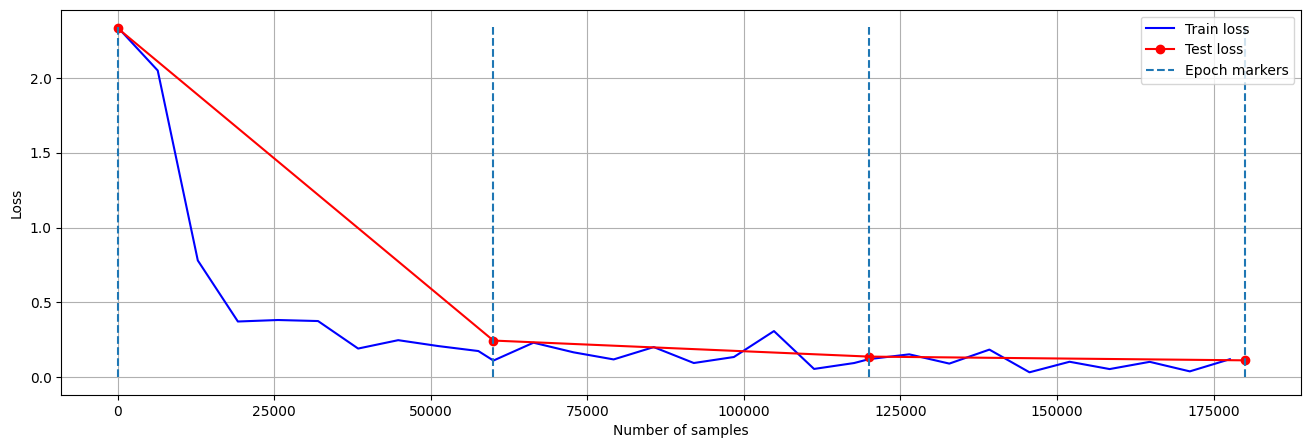

In [ ]:
fig = plt.figure(figsize=(16, 5))
plt.plot(train_counter3, train_losses3, color='blue', label='Train loss')
plt.plot(test_counter3, test_losses3, color='red',  marker='o', label='Test loss')
plt.vlines(test_counter3, 0, max(train_losses3 + test_losses3), linestyles='dashed', label='Epoch markers')

plt.legend(loc='upper right')
plt.xlabel('Number of samples')
plt.ylabel('Loss')
plt.grid()

**Nadopunite bilježnicu sa svim traženim arhitekturama i learning rateovima zadanim u ovom podzadatku.**

#### Podzadatak g) - Usporedba rezultata

Nakon što smo izvršili sve eksperimente potrebno ih je usporediti. Nacrtajte tražene grafove, te pomoću njih odgovorite na pitanja postavljena na Moodleu.

Nacrtajte graf gdje je X os vrijeme (odgovara na pitanje: koji korak treniranja?), a Y os je loss za **trening** skup podataka.

Odgovorite na sljedeća pitanja:
1. Radi li se o konzistentnom padu iz koraka u korak?
2. Jesu li neke arhitekture u startu značajno bolje od drugih?
3. Koji model je najnestabilniji tijekom treniranja?

Text(0.5, 0, 'Steps')

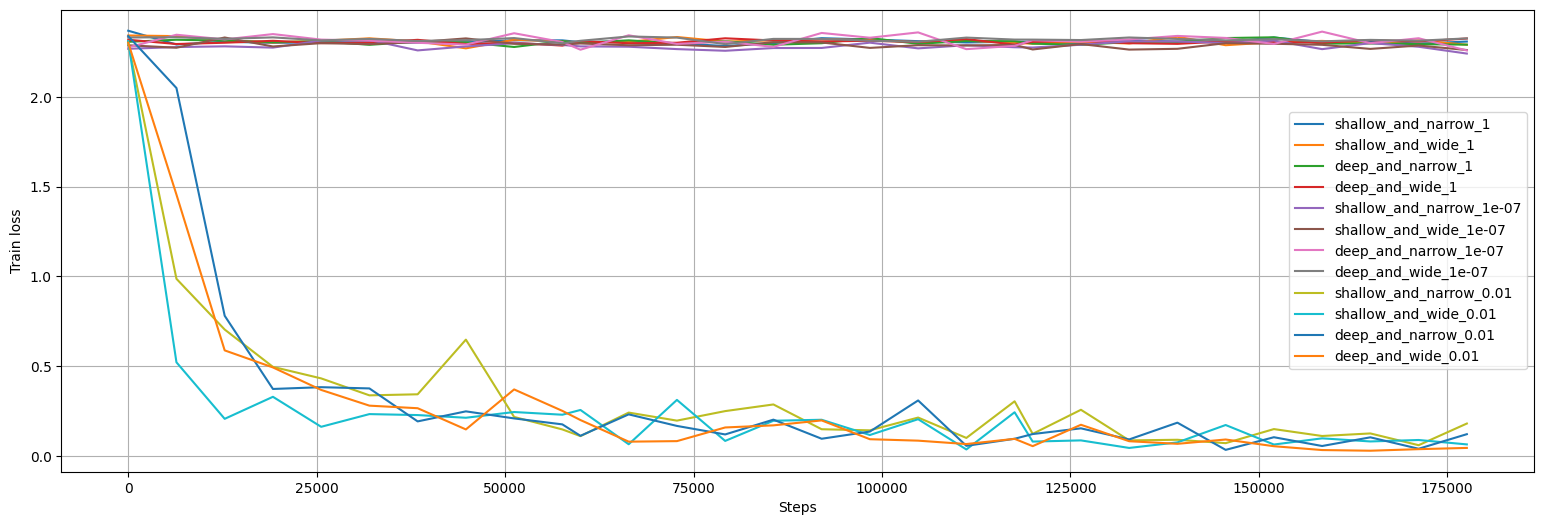

In [ ]:
plt.figure(figsize=(19, 6))

for model_key in results:
    train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters = results[model_key]
    plt.plot(train_counter, train_losses, label=model_key)

plt.legend()
plt.grid()
plt.ylabel("Train loss")
plt.xlabel("Steps")

Nacrtajte graf gdje je X os vrijeme (odgovara na pitanje: koji korak treniranja?), a Y os je loss za **test** skupu podataka.

Odgovorite na sljedeća pitanja:
4. Radi li se o konzistentnom padu iz koraka u korak?
5. Jesu li neke arhitekture u startu značajno bolje od drugih?

Text(0, 0.5, 'Steps')

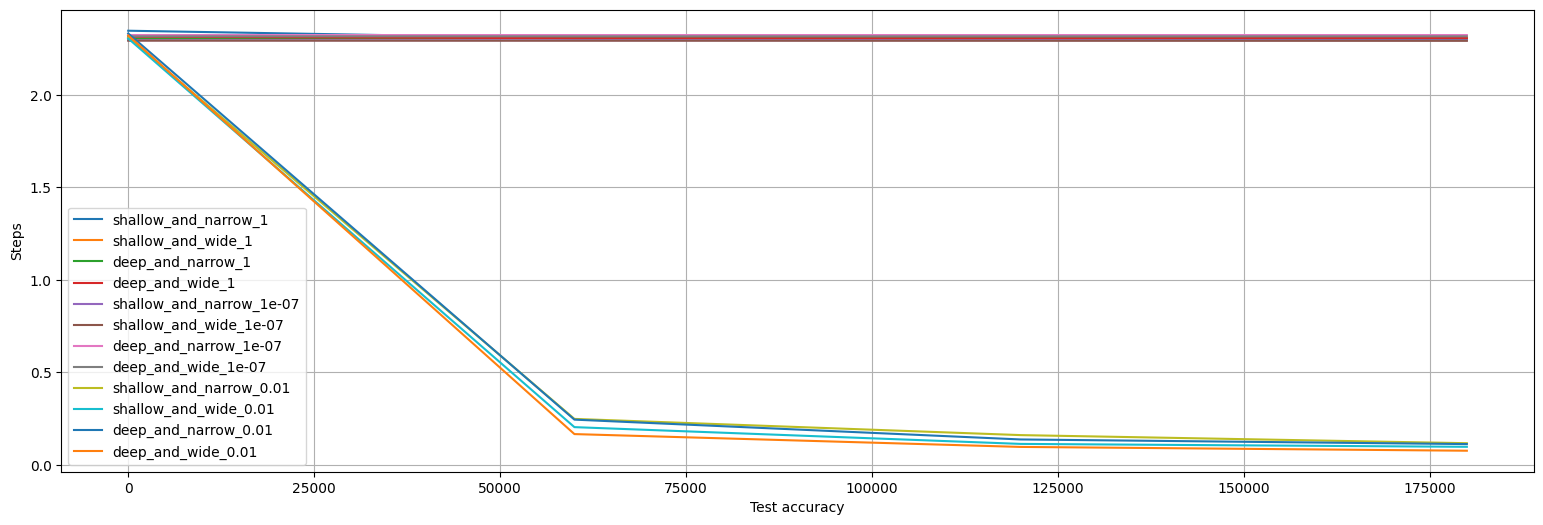

In [ ]:
plt.figure(figsize=(19, 6))

for model_key in results:
    train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters = results[model_key]
    plt.plot(test_counter, test_losses, label=model_key)

plt.legend()
plt.grid()
plt.xlabel("Test accuracy")
plt.ylabel("Steps")

Nacrtajte graf (scatter plot) gdje je X os broj parametara modela, a Y os je točnost koju model ostvaruje na test skupu.

Odgovorite na sljedeća pitanja:
6. Koji je najbolji model?
7. Kakvi su duboki modeli u usporedbu s plitkim modelima?
8. Kakvi su široki modeli u usporedbi s uskima?

Text(0.5, 0, 'Number of parameters')

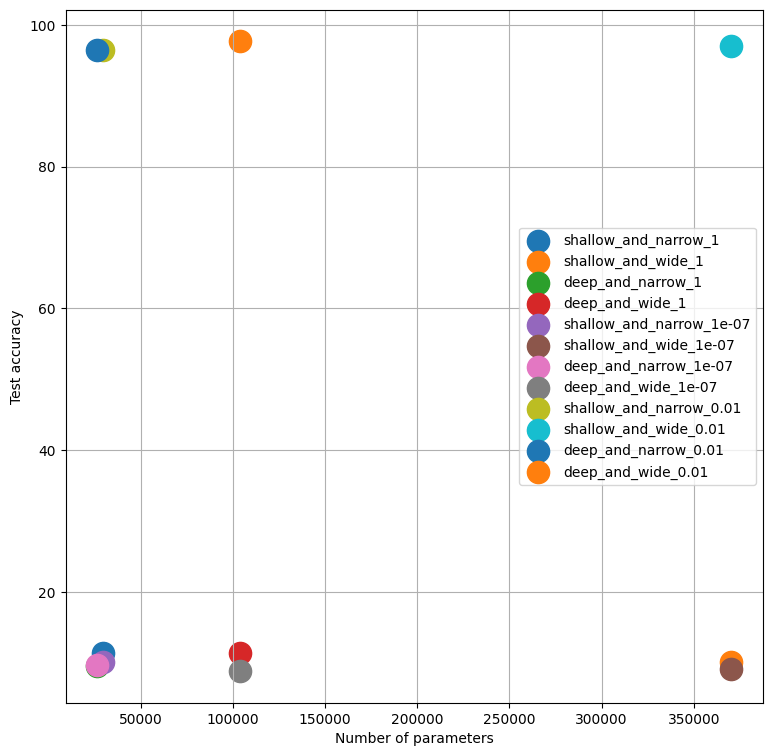

In [ ]:
plt.figure(figsize=(9, 9))

for model_key in results:
    train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters = results[model_key]
    plt.scatter(number_of_parameters, test_accuracy[-1], label=model_key, s=256)


plt.legend()
plt.grid()
plt.ylabel("Test accuracy")
plt.xlabel("Number of parameters")

#### Podzadatak h) - Evaluacija na neviđenom skupu podataka

Preuzmite skup podataka za ocjenjivanje sa sljedeće poveznice: https://drive.google.com/drive/folders/1baSno2jQSlyCPhk_liDlVvgXrIM5ojBB  
-> **submission_z1.zip**

Primjer filea kojeg treba generirati možete preuzeti sa: https://drive.google.com/drive/folders/1baSno2jQSlyCPhk_liDlVvgXrIM5ojBB

-> **zad1_submission_sample.csv**

Odredite predikcije Vašeg najboljeg modela nad tim skupom, te ih stavite na Moodle.

Prije pokretanja iduće ćelije svakako prenesite zip datoteku u radno okruženje.

In [ ]:
import zipfile
import os
import csv

# with zipfile.ZipFile('submission_z1.zip', 'r') as zip_ref:
#     zip_ref.extractall('data')

model = network4
model = model.to(device)
model.eval()

transform = torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Grayscale(num_output_channels=1),
                                torchvision.transforms.Normalize((0.1307,), (0.3081,))]
                               )

dataset = torchvision.datasets.ImageFolder('data', transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

results = []

for ind, (images, _) in enumerate(dataloader):
    images = images.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    image_name = dataset.imgs[ind][0].split('/')[-1]  # Extract image name
    results.append((image_name, predicted.item()))

sorted_results = sorted(results, key=lambda x: int(x[0].split('_')[1][:-4]))

with open('submission_z1.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_name', 'true_label'])
    writer.writerows(sorted_results)

## Zadatak 2 - Pronalazak znamenki na slici i klasifikacija pronađene znamenke

Drugi zadatak je proširenje naučenog u prvom zadatku. Problem se proširuje - umjesto klasifikacije rukom pisane znamenke, naš problem je sada pronalazak rukom pisane znamenke na slici **i** klasifikacija.

Kao i u prethodnoj vježbi, dani su dijelovi koda potrebnog za ostvarenje vježbe, a na Vama je da nadopunite dijelove koji nedostaju.

#### Skup podataka

Da bi mogli trenirati model za klasifikaciju i detekciju objekta na slici, moramo imati odgovarajući dataset. Koristimo postojeći MNIST dataset, a modificiramo ga tako da postavimo originalni MNIST uzorak na slučajnu poziciju na praznoj slici. Sljedeći kod generira takve uzorke, vraćajući modificiranu sliku, oznaku kategorije i poziciju znamenke na slici (*bounding box*).

In [ ]:
class PositionMNIST(Dataset):

    def __init__(self, image_size=128, transform=None, train_set=False):
        self.image_size = image_size
        self.transform = transform

        self.set = torchvision.datasets.MNIST('./files/', train=train_set, download=True)
        self.position_cache = [-1] * len(self.set)

    def __len__(self):
        return len(self.set)

    def __getitem__(self, idx):
        if self.position_cache[idx] == -1:
            x_pos = int(np.random.uniform(0, self.image_size-29))
            y_pos = int(np.random.uniform(0, self.image_size-29))
            self.position_cache[idx] = (x_pos, y_pos)

        x_pos, y_pos = self.position_cache[idx]

        canvas = np.zeros((self.image_size, self.image_size, 1), dtype=np.uint8)
        canvas[y_pos:(y_pos+28), x_pos:(x_pos+28), 0] = self.set[idx][0]

        x_pos = float(x_pos)
        y_pos = float(y_pos)

        if self.transform is not None:
            canvas = self.transform(canvas)

        return canvas, self.set[idx][1], (x_pos, y_pos, x_pos+28, y_pos+28)

In [ ]:
batch_size_train = 128
batch_size_test = 128
image_size = 128

train_set = PositionMNIST(train_set=True, image_size=image_size, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

test_set = PositionMNIST(train_set=False, image_size=image_size, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

100%|██████████| 9912422/9912422 [00:00<00:00, 79607610.12it/s]


Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 107964076.49it/s]


Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29939312.62it/s]


Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4119033.25it/s]


Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw



In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size_test, shuffle=True)

#### Podzadatak a) - Vizualizacija podataka

Uzmite jedan uzorak pomoću data loadera i vizualizirajte ga. Neka u titleu piše klasa i lokacija.

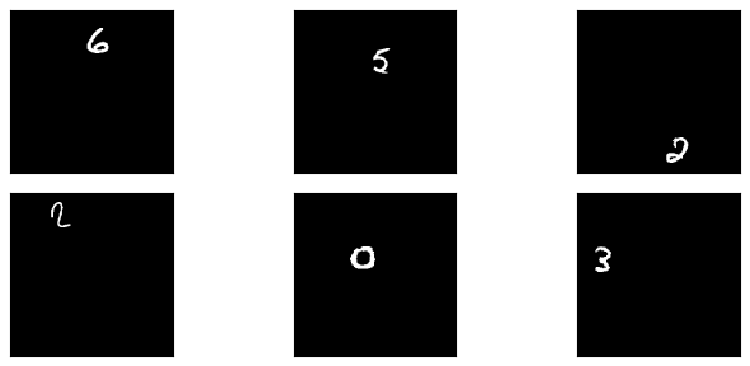

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_label, example_positions) = next(examples)
fig = plt.figure(figsize=(9, 4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    # -----
    image = example_data[i][0].squeeze().numpy()
    label = example_label[i]
    plt.imshow(image, cmap='gray', interpolation='none')
    # -----
    plt.xticks([])
    plt.yticks([])


#### Podzadatak b) - Pomoćne funkcije za treniranje

Nadopunite pomoćne funkcije za treniranje neuronskih mreža po principu naučenom u 1. zadatku. Temeljna razlika između pomoćne funkcije iz prethodnog zadatke i pomoćne funkcije u ovom zadatku je:

1. Rukovanje s podacima (ovdje ih ima više)
2. Drugi problem rješavamo, stoga trebamo drugačiju loss funkciju.

Loss funkcija će se u ovom slučaju sastojati od dva dijela - loss za klasifikaciju s kojim smo se već upoznali, i prosječan kvadrat greške (*mean squared error*) za određivanje pozicije. Loss će se računa kao:

$ \mathcal{L} = \text{NLLLoss}(\text{classification output}, \text{target)} + \frac{(x_1 - \hat{x}_1)^2 + (y_1 - \hat{y}_1)^2 + (x_2 - \hat{x}_2)^2 + (y_2 - \hat{y}_2)^2}{128 \cdot 128}  $

Pri čemu su $x$ i $y$ točne pozicije objekta na slici, a $\hat{x}$ i $\hat{y}$ su modelom određene pozicije objekta.


In [ ]:
def train_step(network, train_loader, optimizer, epoch, device='cuda', log_interval=100, verbose=True):
    train_losses = []
    train_counter = []

    network.train()

    for batch_idx, (data, target, position) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        # -------
        position = [x.to(device).float() for x in position]
        output, pred_x1, pred_y1, pred_x2, pred_y2 = network(data)

        # Compute classification loss
        classification_loss = F.nll_loss(output, target)

        # Compute MSE loss for position
        mse_loss = F.mse_loss(pred_x1, position[0]) / (128 * 128) + \
                  F.mse_loss(pred_y1, position[1]) / (128 * 128) + \
                  F.mse_loss(pred_x2, position[2]) / (128 * 128) + \
                  F.mse_loss(pred_y2, position[3]) / (128 * 128)

        loss = classification_loss + mse_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # -------

        if batch_idx % log_interval == 0:
            if verbose:
                print('Train Epoch: {:5d} [{:5d}/{:5d} ({:2.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item()))

            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

    return train_losses, train_counter

Po istom principu iz 1. zadatka nadopunite funkciju za evaluaciju modela. U ovom slučaju mjerimo 3 stvari: sam loss, točnost klasifikacije i posebno loss za detekciju.

In [ ]:
def test(network, test_loader, device, verbose=True):
    network.eval()

    test_loss_clsf = 0
    test_loss_bbox = 0
    correct = 0
    with torch.no_grad():
        for data, target, position in test_loader:
            data = data.to(device)
            target = target.to(device)
            position = [x.to(device).float() for x in position]

            # Forward pass
            classification_output, pred_x1, pred_y1, pred_x2, pred_y2 = network(data)

            # Compute classification loss
            test_loss_clsf += F.nll_loss(classification_output, target, reduction='sum').item()

            # Compute bounding box loss (Mean Squared Error)
            test_loss_bbox += (F.mse_loss(pred_x1, position[0], reduction='sum').item() + \
                               F.mse_loss(pred_y1, position[1], reduction='sum').item() + \
                               F.mse_loss(pred_x2, position[2], reduction='sum').item() + \
                               F.mse_loss(pred_y2, position[3], reduction='sum').item()) / (128*128)

            # Compute accuracy
            pred = classification_output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss_clsf /= len(test_loader.dataset)
    test_loss_bbox /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    if verbose:
        print('\n[Test] Classification: Avg. loss: {:.4f}, Accuracy: {:5d}/{:5d} ({:2.2f}%) | Object detection: Avg. loss: {:.4f}\n'.format(
            test_loss_clsf,
            correct,
            len(test_loader.dataset),
            test_accuracy,
            test_loss_bbox))

    return test_loss_clsf, test_accuracy, correct, test_loss_bbox


Pomoćna funkcija za provođene eksperimenata iz prethodnog zadatka je iskoristiva do na praćenje dodatnih metrika. Proširite tu funkciju za ovaj zadatak.

In [ ]:
def train_network(network, train_loader, test_loader, device='cuda'):
    train_losses = []
    train_counter = []
    test_losses_clsf = []
    test_accuracies = []
    test_losses_bbox = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

    # Test the randomly initialized model
    test_loss_clsf, test_accuracy, _, test_loss_bbox = test(network, test_loader, device)
    test_losses_clsf.append(test_loss_clsf)
    test_accuracies.append(test_accuracy)
    test_losses_bbox.append(test_loss_bbox)

    for epoch in range(1, n_epochs + 1):
        # Train the model for one epoch
        new_train_losses, new_train_counter = train_step(network, train_loader, optimizer, epoch)
        train_losses.extend(new_train_losses)
        train_counter.extend(new_train_counter)

        # Test the model after training for the epoch
        test_loss_clsf, test_accuracy, _, test_loss_bbox = test(network, test_loader, device)
        test_losses_clsf.append(test_loss_clsf)
        test_accuracies.append(test_accuracy)
        test_losses_bbox.append(test_loss_bbox)

    # Calculate the total test losses
    test_losses_total = [test_losses_clsf, test_accuracies, test_losses_bbox]

    return train_losses, train_counter, test_losses_clsf, test_accuracies, test_losses_bbox, test_counter


## Provođenje eksperimenata i analiza rezultata

#### Podzadatak c) - Izrada modela koji točno klasificira i locira objekt na slici

Kao i u prethodnom zadatku, prvo je potrebno podesiti parametre. Parametri su isti, no ponovimo:
* n_epochs - broj epoha eksperimenta
* learning_rate - stopa učenja
* log_interval - broj koraka između dva ispisa tijekom treniranja (ispis se dešava samo ako se funkcija poziva s argumentom verbose=True)
* device - oznaka na kojem se uređaju izvršava eksperiment; "cuda" za GPU, "cpu" za CPU

In [ ]:
n_epochs = 3
learning_rate = 0.0005
momentum = 0.9
log_interval = 100
device = 'cuda'

Temeljna razlika u arhitekturi modela ovog zadatka i arhitekture modela iz prethodnog zadatka je broj izlaza. Prošla neuronska mreža je imala 10 izlaznih neurona - svaki za jednu klasu. Ova neuronska mreža ima 14 izlaza - 10 za svaku klasu za klasifikacijski problem i 4 za svaku koordinatu rezultirajućeg bounding boxa objekta.

Na temelju iskustva iz 1. zadatka, nadopunite sljedeći model da bi riješili problem:

In [ ]:
class Net(nn.Module):
    def __init__(self, image_size):
        super(Net, self).__init__()
        self.image_size = image_size

        # --------
        # Ovdje je dan primjer jednog ulaznog conv sloja i oblika izlaznih slojeva za orijentaciju

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)

        self.obj_x1_out = nn.Linear(1, 1)
        self.obj_y1_out = nn.Linear(1, 1)
        self.obj_x2_out = nn.Linear(1, 1)
        self.obj_y2_out = nn.Linear(1, 1)
        # --------

    def forward(self, x):
        # ---- ovdje nadopunite ostatak mreže
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.interpolate(x, size=(self.image_size // 4, self.image_size // 4), mode='bilinear', align_corners=False)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # -------- izlaz za klasifikaciju
        clsf = F.log_softmax(x, dim=1)

        # -------- izlaz za detekciju
        x1 = F.relu(self.obj_x1_out(x))
        y1 = F.relu(self.obj_y1_out(x))
        x2 = F.relu(self.obj_x2_out(x))
        y2 = F.relu(self.obj_y2_out(x))

        return clsf, x1.squeeze(), y1.squeeze(), x2.squeeze(), y2.squeeze()

In [ ]:
network = Net(image_size).to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [ ]:
number_of_params = get_number_of_model_parameters(network)
print("Broj parametara u modelu:", number_of_params)

Broj parametara u modelu: 134426382


In [ ]:
train_losses, train_counter, test_losses_clsf, test_accuracies, test_losses_bbox, test_counter = train_network(network, train_loader, test_loader, device)

RuntimeError: shape '[-1, 131072]' is invalid for input of size 14745600

**Vizualizacija metrika uspješnosti**

Vizualizirajte si sve metrike na sljedećem grafu: train_losses, test_losses_total, test_losses_clsf i test_losses_bbox. Pripazite što vam je na x osi!

In [ ]:
test_losses_total = np.array(test_losses_clsf) + np.array(test_losses_bbox)

fig = plt.figure(figsize=(32, 7))
# ----

# ----------

plt.legend(loc='upper right')
plt.xlabel('Number of samples')
plt.ylabel('Loss')
plt.grid()

#### Vizualni pregled - što model estimira?

Iskorisite sljedeći kod da bi vidjeli kako izgledaju predikcije Vašeg modela.

In [ ]:
with torch.no_grad():
    clsf_out, x1_out, y1_out, x2_out, y2_out = network(example_data.to(device))

plt.figure(figsize=(32, 32))
for idx in range(0, example_data.shape[0]):
    image = np.array(example_data[idx, 0, ...]).copy()

    x1, y1, x2, y2 = list(map(lambda x: int(x.item()), [x1_out[idx, ...], y1_out[idx, ...], x2_out[idx, ...], y2_out[idx, ...]]))
    image = cv2.rectangle(image, (x1, y1), (x2, y2), (2.5), 2)

    plt.subplot(12, 12, idx+1)
    plt.imshow(image)
    plt.title(np.argmax(clsf_out[idx, ...].cpu()))
    plt.xticks([])
    plt.yticks([])

#### Podzadatak d) - Evaluacija na neviđenom skupu podataka

Preuzmite skup podataka za ocjenjivanje sa sljedeće poveznice: https://drive.google.com/drive/folders/1baSno2jQSlyCPhk_liDlVvgXrIM5ojBB?usp=sharing -> **submission_z2.zip**

Primjer filea kojeg treba generirati možete preuzeti sa: https://drive.google.com/drive/folders/1baSno2jQSlyCPhk_liDlVvgXrIM5ojBB?usp=sharing -> **zad2_submission_sample.csv**

Odredite predikcije Vašeg najboljeg modela nad tim skupom, te ih stavite na Moodle.

In [ ]:
import zipfile
import os
import csv

with zipfile.ZipFile('submission_z2.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

model = network
model = model.to(device)
model.eval()

transform = torchvision.transforms.Compose([
                                torchvision.transforms.Resize((128,128)),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Grayscale(num_output_channels=1),
                                torchvision.transforms.Normalize((0.1307,), (0.3081,))]
                               )

dataset = torchvision.datasets.ImageFolder('data', transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

results = []

for ind, (images, _) in enumerate(dataloader):
    images = images.to(device)

    clsf, x1, y1, x2, y2 = model(images)
    _, predicted_digit = torch.max(clsf, 1)

    image_name = dataset.imgs[ind][0].split('/')[-1]  # Extract image name
    results.append((image_name, predicted_digit.item(), x1.item(), y1.item(), x2.item(), y2.item()))

sorted_results = sorted(results, key=lambda x: int(x[0].split('_')[1][:-4]))

with open('submission_z2.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_name', 'true_label', 'x1', 'y1', 'x2', 'y2'])
    writer.writerows(sorted_results)